# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [10]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib5'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-fullCyc2_lib5.assembled.dmult.fastq')

# number of processors
nprocs = 20

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib5/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib5/pear_merged-fullCyc2_lib5.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-fullCyc2_lib5.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 2733024
Number of sequences post-filter: 2696114

>MR.F.13C-Pal.D14.R1_Frac5_0 orig_name=M02465:324:000000000-AWPVM:1:1101:16781:1371
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTCTTCCAAGTCAGTGGTGAAAGCCC
GGAGCTCAACTCCGGAACTGCCATTGAAACTGTTAGACTTGAGGACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTG
AAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTATCTGACGCTCAGGCGCGACAGCGTG
GGGATCAAACAGG
>MR.F.13C-Van.D6.R1_Frac10_2 orig_name=M02465:324:000000000-AWPVM:1:1101:15077:1372
TACGAAGGGGGCTAGCGTTGTTCGGAATCACTGGGCGTAAAGGGTGCGTAGGCGGGTCTTTAAGTCAGGGGTGAAATCCT
GGAGCTCAACTCCGGAACTGCCTTTGATACTGAGGATCTTGAGTTCGGGAGAGGTGAGTGGAACTGCGAGTGTAGAGGTG


## Remove seqs with 'N' characters

In [11]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.fasta'

In [12]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 2696114
Number of sequences post-filter: 2696114


## Alignment-based QC with Mothur

In [13]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.F.13C-Pal.D14.R1_Frac5_0	MR.F.13C-Pal.D14.R1_Frac5
MR.F.13C-Van.D6.R1_Frac10_2	MR.F.13C-Van.D6.R1_Frac10
MR.M.12C-Con.D30.R1_Frac4_1	MR.M.12C-Con.D30.R1_Frac4
MR.F.13C-Van.D6.R1_Frac27_4	MR.F.13C-Van.D6.R1_Frac27
MR.F.13C-Van.D6.R1_Frac13_5	MR.F.13C-Van.D6.R1_Frac13
MR.F.13C-Van.D6.R1_Frac8_7	MR.F.13C-Van.D6.R1_Frac8
MR.F.13C-Van.D6.R1_Frac24_8	MR.F.13C-Van.D6.R1_Frac24
MR.M.12C-Con.D14.R1_Frac23_6	MR.M.12C-Con.D14.R1_Frac23
MR.F.13C-Pal.D14.R1_Frac8_9	MR.F.13C-Pal.D14.R1_Frac8
MR.M.13C-Cel.D6.R1_Frac25_12	MR.M.13C-Cel.D6.R1_Frac25


In [14]:
! head -n 200 group_file.txt

MR.F.13C-Pal.D14.R1_Frac5_0	MR.F.13C-Pal.D14.R1_Frac5
MR.F.13C-Van.D6.R1_Frac10_2	MR.F.13C-Van.D6.R1_Frac10
MR.M.12C-Con.D30.R1_Frac4_1	MR.M.12C-Con.D30.R1_Frac4
MR.F.13C-Van.D6.R1_Frac27_4	MR.F.13C-Van.D6.R1_Frac27
MR.F.13C-Van.D6.R1_Frac13_5	MR.F.13C-Van.D6.R1_Frac13
MR.F.13C-Van.D6.R1_Frac8_7	MR.F.13C-Van.D6.R1_Frac8
MR.F.13C-Van.D6.R1_Frac24_8	MR.F.13C-Van.D6.R1_Frac24
MR.M.12C-Con.D14.R1_Frac23_6	MR.M.12C-Con.D14.R1_Frac23
MR.F.13C-Pal.D14.R1_Frac8_9	MR.F.13C-Pal.D14.R1_Frac8
MR.M.13C-Cel.D6.R1_Frac25_12	MR.M.13C-Cel.D6.R1_Frac25
MR.M.13C-Van.D6.R1_Frac27_10	MR.M.13C-Van.D6.R1_Frac27
MR.F.13C-Pal.D14.R1_Frac5_11	MR.F.13C-Pal.D14.R1_Frac5
MR.F.13C-Pal.D14.R1_Frac14_15	MR.F.13C-Pal.D14.R1_Frac14
MR.M.12C-Con.D14.R1_Frac7_14	MR.M.12C-Con.D14.R1_Frac7
MR.F.13C-Van.D6.R1_Frac28_16	MR.F.13C-Van.D6.R1_Frac28
MR.F.13C-Pal.D14.R1_Frac5_13	MR.F.13C-Pal.D14.R1_Frac5
MR.F.13C-Van.D6.R1_Frac20_18	MR.F.13C-Van.D6.R1_Frac20
MR.F.13C-Van.D6.R1_Frac16_17	MR.F.13C-Van.D6.R1_Frac16
MR.A.13C-Xyl.D14.

In [15]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

2675000	1636570
2676000	1637147
2677000	1637693
2678000	1638260
2679000	1638818
2680000	1639371
2681000	1639922
2682000	1640509
2683000	1641070
2684000	1641633
2685000	1642232
2686000	1642772
2687000	1643402
2688000	1644002
2689000	1644626
2690000	1645212
2691000	1645820
2692000	1646475
2693000	1647183
2694000	1647831
2695000	1648524
2696000	1649239
2696114	1649329

Output File Names: 
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.names
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [16]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 1649329


In [17]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 141M May 16 08:30 pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.names


In [18]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-16 08:30:50--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.87M 10s
    50K .......... .......... .......... .......... ..........  0%  996K 15s
   100K .......... .......... .......... .......... ..........  0% 1.49M 14s
   150K .......... .......... .......... .......... ..........  1% 1.00M 15s
   200K .......... .......... .......... .......... ..........  1% 1.48M 14s
   250K .......... .......... .......... .......... ..........  1% 1.04M 15s
   300K .......... .......... .......... .......... ..........  1% 1.53M 15s
   350K .......... .......... .......... .......... ..........  2%  870K 15s
   400K .......... .......... .......

In [19]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

100
200
300
400
500
560



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [20]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors={}, flip=T)"'.format(qcFile3a, silvaFileFilt, nprocs)
!$cmd | tail -n 30

82000
82100
82200
82300
82400
82500
82600
82700
82800
82871
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 638 secs to align 1649329 sequences.


Output File Names: 
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.align
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>

In [21]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 16G May 16 08:41 pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.align


In [22]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

81000
81100
81200
81300
81400
81500
81600
81700
81800
81900
82000
82100
82200
82300
82400
82480



Length of filtered alignment: 1347
Number of columns removed: 8833
Length of the original alignment: 10180
Number of sequences used to construct filter: 1649329

Output File Names: 
pear_merged-fullCyc2_lib5.filter
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [23]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 2.2G May 16 08:43 pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.fasta


In [24]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	221	959	253	0	4	67403
25%-tile:	221	959	253	0	4	674029
Median: 	221	959	253	0	5	1348058
75%-tile:	221	959	253	0	6	2022086
97.5%-tile:	221	959	254	0	8	2628712
Maximum:	1347	1347	366	0	55	2696114
Mean:	222.415	958.778	252.526	0	4.92467
# of unique seqs:	1649329
total # of seqs:	2696114

Output File Names: 
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.summary

It took 9 secs to summarize 2696114 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [25]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 221, 959)
!$cmd | tail -n 30

Processing sequence: 80800
Processing sequence: 80900
Processing sequence: 81000
Processing sequence: 81100
Processing sequence: 81200
Processing sequence: 81300
Processing sequence: 81400
Processing sequence: 81500
Processing sequence: 81600
Processing sequence: 81700
Processing sequence: 81800
Processing sequence: 81900
Processing sequence: 82000
Processing sequence: 82100
Processing sequence: 82200
Processing sequence: 82300
Processing sequence: 82400
Processing sequence: 82500
Processing sequence: 82560

Output File Names: 
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 17 secs to screen 1649329 sequences.

mothur > quit()


In [26]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 1615353


In [27]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

80400
80500
80600
80700
80800
80860



Length of filtered alignment: 934
Number of columns removed: 413
Length of the original alignment: 1347
Number of sequences used to construct filter: 1615353

Output File Names: 
pear_merged-fullCyc2_lib5.filter
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [28]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 1.5G May 16 08:44 pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [29]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-fullCyc2_lib5.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [30]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [31]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	213	213	0	3	1
2.5%-tile:	1	253	253	0	4	66191
25%-tile:	1	253	253	0	4	661909
Median: 	1	253	253	0	5	1323818
75%-tile:	1	253	253	0	6	1985727
97.5%-tile:	1	254	254	0	8	2581445
Maximum:	1	366	366	0	8	2647635
Mean:	1	253.077	253.077	0	4.91249
# of Seqs:	2647635

Output File Names: 
finalQC.summary

It took 2 secs to summarize 2647635 sequences.

mothur > quit()


In [32]:
!head -n 6 $qcFinal

>MR.F.13C-Pal.D14.R1_Frac5_0
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTCTTCCAAGTCAGTGGTGAAAGCCCGGAGCTCAACTCCGGAACTGCCATTGAAACTGTTAGACTTGAGGACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTATCTGACGCTCAGGCGCGACAGCGTGGGGATCAAACAGG
>MR.F.13C-Van.D6.R1_Frac10_24154
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTCTTCCAAGTCAGTGGTGAAAGCCCGGAGCTCAACTCCGGAACTGCCATTGAAACTGTTAGACTTGAGGACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTATCTGACGCTCAGGCGCGACAGCGTGGGGATCAAACAGG
>MR.F.13C-Van.D6.R1_Frac5_153329
TACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCGCGCAGGCGGTCTTCCAAGTCAGTGGTGAAAGCCCGGAGCTCAACTCCGGAACTGCCATTGAAACTGTTAGACTTGAGGACGAGAGAGGTGAGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCTCACTGGCTCGTATCTGACGCTCAGGCGCGACAGCGTGGGGATCAAACAGG


## Summary of number of seqs per sample

In [33]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [34]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.F.13C-Pal.D14.R1_Frac5,39730
1,MR.F.13C-Van.D6.R1_Frac10,18671
2,MR.F.13C-Van.D6.R1_Frac5,19562
3,MR.F.13C-Pal.D14.R1_Frac4,38577
4,MR.M.13C-Cel.D6.R1_Frac7,9119
5,MR.M.13C-Cel.D6.R1_Frac22,5580
6,MR.F.13C-Pal.D14.R1_Frac17,45643
7,MR.F.13C-Pal.D14.R1_Frac12,28531
8,MR.F.13C-Pal.D14.R1_Frac11,59241
9,MR.M.13C-Cel.D6.R1_Frac9,17188


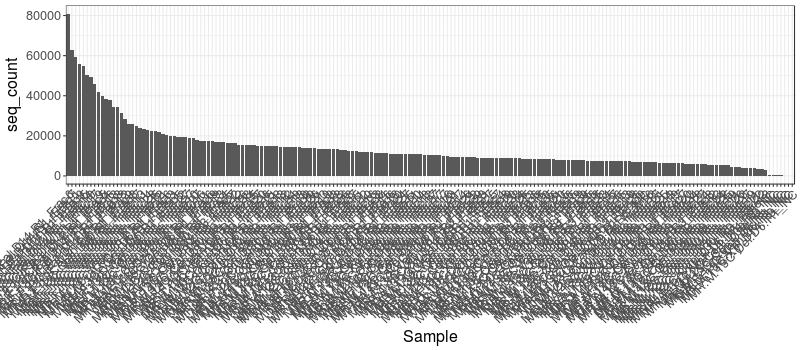

In [35]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [37]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 5000,]

                        Sample seq_count rank
176 MR.M.13C-Cel.D30.R3_Frac19      4314   17
177 MR.M.13C-Cel.D30.R3_Frac11      4304   16
178 MR.M.12C-Con.D30.R1_Frac26      4247   15
179 MR.M.12C-Con.D30.R1_Frac23      4024   14
180 MR.M.12C-Con.D14.R1_Frac27      3988   13
181 MR.M.12C-Con.D14.R1_Frac19      3853   12
182 MR.M.12C-Con.D14.R1_Frac11      3847   11
183 MR.M.12C-Con.D30.R1_Frac22      3258   10
184 MR.A.13C-Xyl.D14.R3_Frac22      3246    9
185  MR.F.13C-Van.D6.R1_Frac18      2897    8
186     MR.M.12C-Con.D14.R1_NC       695    7
187     MR.M.13C-Cel.D30.R3_NC       580    6
188     MR.M.12C-Con.D30.R1_NC       540    5
189      MR.F.13C-Van.D6.R1_NC       375    4
190      MR.M.13C-Van.D6.R1_NC       159    3
191     MR.A.13C-Xyl.D14.R3_NC       122    2
192      MR.M.13C-Cel.D6.R1_NC        73    1
